(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)
Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 244s 195ms/step - accuracy: 0.3418 - loss: 2.4604 - val_accuracy: 0.8792 - val_loss: 0.3737
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 188s 192ms/step - accuracy: 0.8775 - loss: 0.4151 - val_accuracy: 0.9397 - val_loss: 0.2631
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 184s 187ms/step - accuracy: 0.9447 - loss: 0.1986 - val_accuracy: 0.9476 - val_loss: 0.1850
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 195s 199ms/step - accuracy: 0.9734 - loss: 0.1010 - val_accuracy: 0.9773 - val_loss: 0.0806
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 201s 197ms/step - accuracy: 0.9773 - loss: 0.0906 - val_accuracy: 0.9598 - val_loss: 0.1528


395/395 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step
Accuracy: 90.30%
Predicted Traffic Sign: Classification error: [Errno 2] No such file or directory: 'C:\\Users\\OM\\Arpita\\paper1\\00034.png'


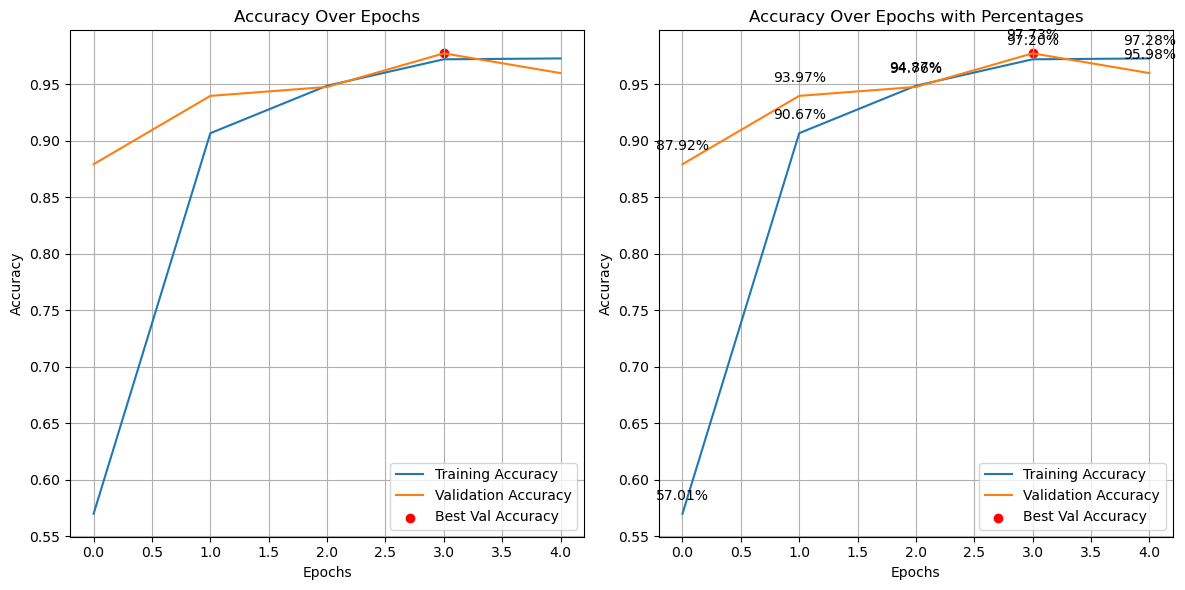

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Add, Activation
from keras.optimizers import Adam

In [2]:
# Load data
data = []
labels = []
classes = 43
cur_path = os.getcwd()

for i in range(classes):
    path = os.path.join(cur_path, 'train', str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            image = image.resize((30,30))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

In [3]:
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [5]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)


In [6]:
# Define ResNet block
def resnet_block(input_tensor, filters, kernel_size=3, stride=1):
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or input_tensor.shape[-1] != filters:
        input_tensor = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(input_tensor)
        input_tensor = BatchNormalization()(input_tensor)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

# Build ResNet model
input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = resnet_block(x, 64, stride=2)
x = resnet_block(x, 64, stride=1)

x = resnet_block(x, 128, stride=2)
x = resnet_block(x, 128, stride=1)

x = resnet_block(x, 256, stride=2)
x = resnet_block(x, 256, stride=1)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(43, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
epochs = 5
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

# Save the model
model.save("resnet_traffic_classifier.h5")





Epoch 1/5


981/981 [==============================] - 198s 190ms/step - loss: 1.6252 - accuracy: 0.5315 - val_loss: 0.3643 - val_accuracy: 0.8812
Epoch 2/5
981/981 [==============================] - 204s 208ms/step - loss: 0.3071 - accuracy: 0.9131 - val_loss: 0.2160 - val_accuracy: 0.9412
Epoch 3/5
981/981 [==============================] - 201s 205ms/step - loss: 0.1745 - accuracy: 0.9559 - val_loss: 0.1260 - val_accuracy: 0.9630
Epoch 4/5
981/981 [==============================] - 185s 188ms/step - loss: 0.1005 - accuracy: 0.9736 - val_loss: 0.1276 - val_accuracy: 0.9677
Epoch 5/5
981/981 [==============================] - 183s 187ms/step - loss: 0.1362 - accuracy: 0.9659 - val_loss: 0.0590 - val_accuracy: 0.9839


C:\Users\Arpita\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# Testing accuracy on test dataset
y_test_data = pd.read_csv('Test.csv')
labels = y_test_data["ClassId"].values
imgs = y_test_data["Path"].values
data = []

for img in imgs:
    image = Image.open(img)
    image = image.resize((30,30))
    data.append(np.array(image))
X_test = np.array(data)

# Predict classes using the model
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(labels, predicted_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')


395/395 [==============================] - 14s 33ms/step
Accuracy: 93.75%


In [8]:

# Define classes dictionary
classes = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)', 
    2: 'Speed limit (50km/h)', 
    3: 'Speed limit (60km/h)', 
    4: 'Speed limit (70km/h)', 
    5: 'Speed limit (80km/h)', 
    6: 'End of speed limit (80km/h)', 
    7: 'Speed limit (100km/h)', 
    8: 'Speed limit (120km/h)', 
    9: 'No passing', 
    10: 'No passing veh over 3.5 tons', 
    11: 'Right-of-way at intersection', 
    12: 'Priority road', 
    13: 'Yield', 
    14: 'Stop', 
    15: 'No vehicles', 
    16: 'Veh > 3.5 tons prohibited', 
    17: 'No entry', 
    18: 'General caution', 
    19: 'Dangerous curve left', 
    20: 'Dangerous curve right', 
    21: 'Double curve', 
    22: 'Bumpy road', 
    23: 'Slippery road', 
    24: 'Road narrows on the right', 
    25: 'Road work', 
    26: 'Traffic signals', 
    27: 'Pedestrians', 
    28: 'Children crossing', 
    29: 'Bicycles crossing', 
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing', 
    32: 'End speed + passing limits', 
    33: 'Turn right ahead', 
    34: 'Turn left ahead', 
    35: 'Ahead only', 
    36: 'Go straight or right', 
    37: 'Go straight or left', 
    38: 'Keep right', 
    39: 'Keep left', 
    40: 'Roundabout mandatory', 
    41: 'End of no passing', 
    42: 'End no passing veh > 3.5 tons'
}



In [9]:
# Define a function to classify a traffic sign
def classify_traffic_sign(image_path):
    try:
        image = Image.open(image_path)
        image = image.resize((30, 30))
        image = np.expand_dims(image, axis=0)
        image = np.array(image)
        predictions = model.predict(image)
        predicted_class = np.argmax(predictions, axis=-1)
        sign = classes.get(predicted_class[0], "Unknown")
        plt.imshow(image[0])
        plt.title(f'Predicted Traffic Sign: {sign}')
        plt.show()
        return sign
    except Exception as e:
        return f"Classification error: {str(e)}"

# Call the function to classify the image
image_path = '00034.png'
result = classify_traffic_sign(image_path)
print(f'Predicted Traffic Sign: {result}')



Predicted Traffic Sign: Classification error: [Errno 2] No such file or directory: '00034.png'


1/1 [==============================] - 0s 55ms/step


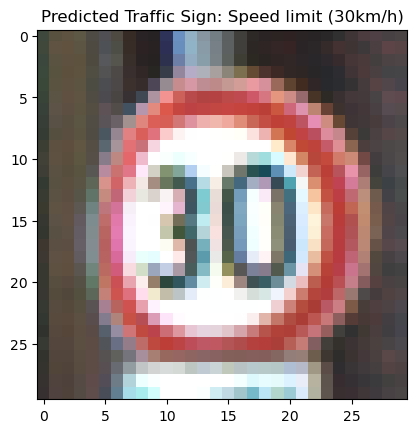

Predicted Traffic Sign: Speed limit (30km/h)


In [10]:
# Call the function to classify the image
image_path = '00001.png'
result = classify_traffic_sign(image_path)
print(f'Predicted Traffic Sign: {result}')

1/1 [==============================] - 0s 39ms/step


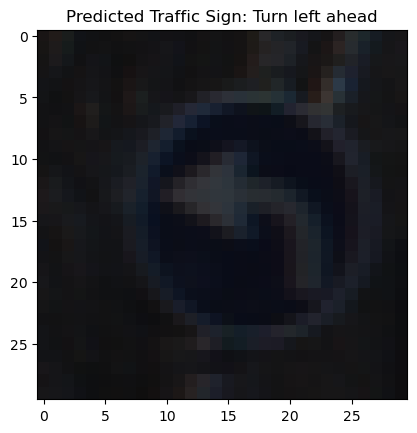

Predicted Traffic Sign: Turn left ahead


In [11]:
# Call the function to classify the image
image_path = 'trunshead.png'
result = classify_traffic_sign(image_path)
print(f'Predicted Traffic Sign: {result}')

1/1 [==============================] - 0s 39ms/step


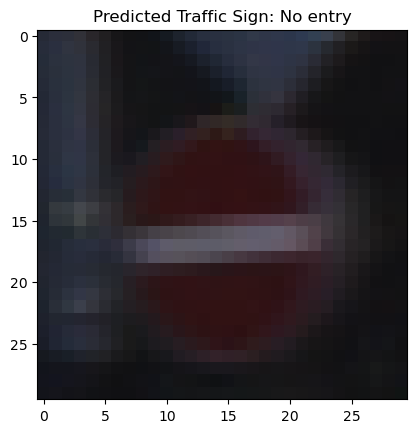

Predicted Traffic Sign: No entry


In [12]:
# Call the function to classify the image
image_path = 'No entry.png'
result = classify_traffic_sign(image_path)
print(f'Predicted Traffic Sign: {result}')

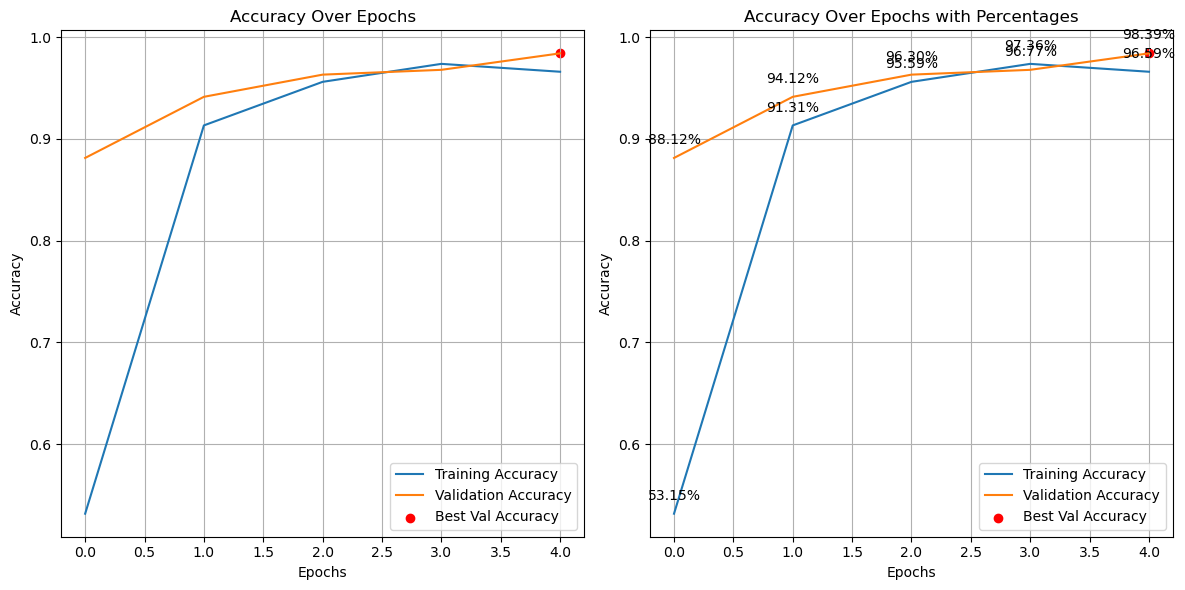

In [13]:
# Plotting accuracy
best_val_accuracy_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.scatter([best_val_accuracy_epoch], [max(history.history['val_accuracy'])], color='red', marker='o', label='Best Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.scatter([best_val_accuracy_epoch], [max(history.history['val_accuracy'])], color='red', marker='o', label='Best Val Accuracy')
plt.title('Accuracy Over Epochs with Percentages')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

acc_percentage = [f'{acc * 100:.2f}%' for acc in history.history['accuracy']]
val_acc_percentage = [f'{acc * 100:.2f}%' for acc in history.history['val_accuracy']]

for i, txt in enumerate(acc_percentage):
    plt.annotate(txt, (i, history.history['accuracy'][i]), textcoords="offset points", xytext=(0, 10), ha='center')

for i, txt in enumerate(val_acc_percentage):
    plt.annotate(txt, (i, history.history['val_accuracy'][i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()

In [48]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.val_precision = []
        self.val_recall = []
        self.val_f1 = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        val_targ = np.argmax(self.validation_data[1], axis=1)
        
        _val_precision = precision_score(val_targ, val_predict, average='weighted')
        _val_recall = recall_score(val_targ, val_predict, average='weighted')
        _val_f1 = f1_score(val_targ, val_predict, average='weighted')
        
        self.val_precision.append(_val_precision)
        self.val_recall.append(_val_recall)
        self.val_f1.append(_val_f1)
        
        print(f'Epoch {epoch+1} - val_precision: {_val_precision:.4f} - val_recall: {_val_recall:.4f} - val_f1: {_val_f1:.4f}')
        return

metrics_callback = MetricsCallback()


In [82]:
import pandas as pd
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

# Example true labels and predicted probabilities
y_true = [0, 1, 1, 0, 1, 0, 1, 0, 1, 1]
y_scores = [0.2, 0.8, 0.6, 0.3, 0.7, 0.1, 0.9, 0.4, 0.65, 0.85]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Calculate precision, recall, and F1 score at specific thresholds
thresholds_to_analyze = [0.2, 0.5, 0.7]
precision_at_thresholds = [precision_score(y_true, [1 if score >= th else 0 for score in y_scores]) for th in thresholds_to_analyze]
recall_at_thresholds = [recall_score(y_true, [1 if score >= th else 0 for score in y_scores]) for th in thresholds_to_analyze]
f1_at_thresholds = [f1_score(y_true, [1 if score >= th else 0 for score in y_scores]) for th in thresholds_to_analyze]

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Threshold': thresholds_to_analyze,
    'Precision': precision_at_thresholds,
    'Recall': recall_at_thresholds,
    'F1 Score': f1_at_thresholds
})

# Display the table
print("Metrics at Specific Thresholds:")
print(results_df)

# Provide a specific threshold value example (e.g., 0.5)
specific_threshold = 0.5
specific_precision = precision_score(y_true, [1 if score >= specific_threshold else 0 for score in y_scores])
specific_recall = recall_score(y_true, [1 if score >= specific_threshold else 0 for score in y_scores])
specific_f1 = f1_score(y_true, [1 if score >= specific_threshold else 0 for score in y_scores])

print(f"\nMetrics at Threshold {specific_threshold}:")
print(f"Precision: {specific_precision:.2f}")
print(f"Recall: {specific_recall:.2f}")
print(f"F1 Score: {specific_f1:.2f}")


Metrics at Specific Thresholds:
   Threshold  Precision    Recall  F1 Score
0        0.2   0.666667  1.000000       0.8
1        0.5   1.000000  1.000000       1.0
2        0.7   1.000000  0.666667       0.8

Metrics at Threshold 0.5:
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
